# Final Project: Predicting San Francisco Crime


#### W207
#### David Harding, Faria Mardhani, Victoria Eastman
#### April 17th, 2018

------------------------------

In the following analysis, we use standard data science and machine learning techniques to analyze 12 years of San Francisco crime data. The kaggle competition (https://www.kaggle.com/c/sf-crime) "San Francisco Crime Classification" tasks entrants with predicting the type of crime using only time and location data from across the Bay Area. 

The first part of our analysis focuses on an EDA of the given training data set. In this analysis, we break down the time of reported crimes by month, day, hour, and minute to isolate peak crime 'times' and determine trends. The dataset contains longitude and latitude data as well as addresses or intersections to identify the location of the crimes. We group these addresses by distribution of crime type to increase our feature space and we compare school location (https://data.sfgov.org/Economy-and-Community/Schools/tpp3-epx2) to crime location to further add color to the location data provided. 

Following the EDA, we train a machine learning algorithm on binarized features contained both in the data set and several we derive ourselves to produce predictions on the test set. Our derived features relate to various breakdowns of the datetime variable and several location-based variables of address clusters and school-location derived relationships. The main text of our notebook contains only our final machine learning model, in this case Bernoulli Naive Bayes, however in the appendix, we include several of the additional models we tried. 

In [1]:
%matplotlib inline

# General libraries.
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

# SK-learn libraries for evaluation.
from sklearn import metrics

# Extra for plotting
import mplleaflet
plt.style.use('fivethirtyeight')

# true division for integers in 2.7
from __future__ import division

C:\Users\dcrha\Anaconda3\envs\Python27\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\dcrha\Anaconda3\envs\Python27\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## I. Exploratory Data Analysis

In [2]:
# import training dataset, drop unwanted columns, and exclude rows with location data outside range

df = pd.read_csv('train.csv', parse_dates=[0])
df = df.drop(['Descript', 'Resolution'], axis=1)

# Isolate category varable (label)
df.Category = df.Category.astype('category')
df['Cat_codes'] = df.Category.cat.codes

# Show data shape and first few rows
print df.shape
print df.head()

# Copy training set to retain clean version for model building later on
df_train = df
print df_train.shape

# Note below that we discard the 67 rows that have incorrect X,Y coordinates
df_train = df_train[df.X < -121]
df_train = df_train[df.Y < 80]
print df_train.shape

(878049, 8)
                Dates        Category  DayOfWeek PdDistrict  \
0 2015-05-13 23:53:00        WARRANTS  Wednesday   NORTHERN   
1 2015-05-13 23:53:00  OTHER OFFENSES  Wednesday   NORTHERN   
2 2015-05-13 23:33:00  OTHER OFFENSES  Wednesday   NORTHERN   
3 2015-05-13 23:30:00   LARCENY/THEFT  Wednesday   NORTHERN   
4 2015-05-13 23:30:00   LARCENY/THEFT  Wednesday       PARK   

                     Address           X          Y  Cat_codes  
0         OAK ST / LAGUNA ST -122.425892  37.774599         37  
1         OAK ST / LAGUNA ST -122.425892  37.774599         21  
2  VANNESS AV / GREENWICH ST -122.424363  37.800414         21  
3   1500 Block of LOMBARD ST -122.426995  37.800873         16  
4  100 Block of BRODERICK ST -122.438738  37.771541         16  
(878049, 8)


C:\Users\dcrha\Anaconda3\envs\Python27\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(877982, 8)


The data has 8 columns, but two of those are labels: Category and Cat_codes. Therefore, we are left with 6 columns of data we can use and manipulate into features to help train our model. The first column of Dates has second-level precision and the address data gives either a numeric address or two cross streets. 

The training set contains over 800,000 entries.

count            878049
unique               39
top       LARCENY/THEFT
freq             174900
Name: Category, dtype: object 

BREAKDOWN OF CRIME TYPE BY %:
LARCENY/THEFT                  19.919162
OTHER OFFENSES                 14.370724
NON-CRIMINAL                   10.512397
ASSAULT                         8.755320
DRUG/NARCOTIC                   6.146696
VEHICLE THEFT                   6.125057
VANDALISM                       5.093679
WARRANTS                        4.807704
BURGLARY                        4.185985
SUSPICIOUS OCC                  3.577705
MISSING PERSON                  2.959858
ROBBERY                         2.619444
FRAUD                           1.899552
FORGERY/COUNTERFEITING          1.208247
SECONDARY CODES                 1.137180
WEAPON LAWS                     0.974319
PROSTITUTION                    0.852344
TRESPASS                        0.834350
STOLEN PROPERTY                 0.517055
SEX OFFENSES FORCIBLE           0.499744
DISORDERLY CONDUCT    

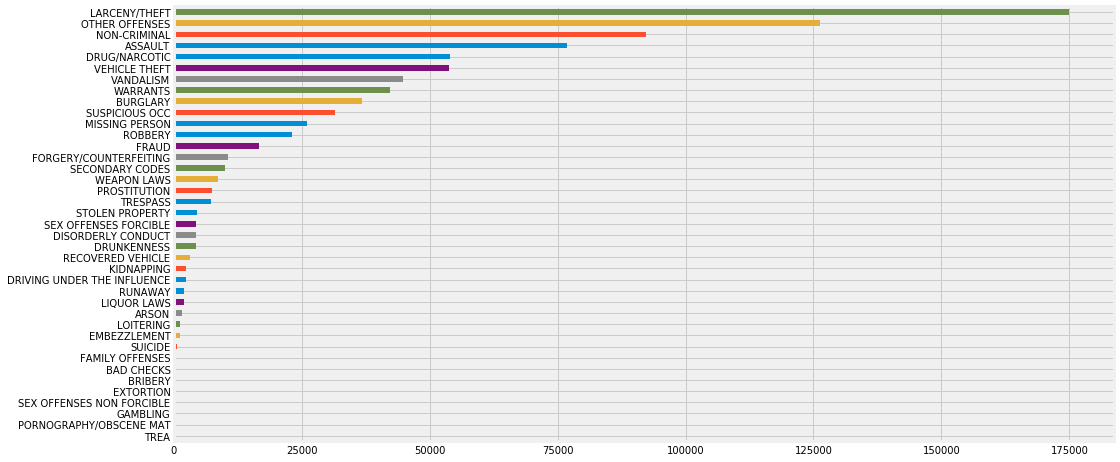

In [3]:
# Check values for crime categories
print df.Category.describe(), '\n'
print "BREAKDOWN OF CRIME TYPE BY %:\n", 100*df.Category.value_counts()/len(df.Category)

# Issue: Top categories 100-1000x more prevalent than bottom categories 
df_ratio = df.Category.value_counts()[::-1]
df_ratio.plot.barh(figsize=(15,8))

As we can see in the chart above, the data is highly skewed with only 4 types of crime accounting for over 50% of all crimes. This is going to cause problems later on because the less common crimes are going to be difficult to predict. 

### a. Date and Time Data

In [4]:
# Add Hours, Days, Months, Years 
df['DOW'] = df.Dates.dt.weekday
df['DOM'] = df.Dates.dt.day
df['HOUR'] = df.Dates.dt.hour
df['MONTH'] = df.Dates.dt.month
df['YEAR'] = df.Dates.dt.year

# Check values for dates
df.Dates.describe()

count                  878049
unique                 389257
top       2011-01-01 00:01:00
freq                      185
first     2003-01-06 00:01:00
last      2015-05-13 23:53:00
Name: Dates, dtype: object

Our dataset contains 12 years of data from 2003 to 2015. 185 crimes occured at 1:00 AM on New Years Eve in 2011. 

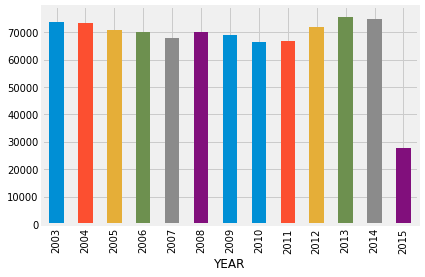

In [5]:
# Crime by year to find any long-term trends
df.groupby(df.YEAR).Dates.count().plot.bar()

Here we look at crimes per year in the data set. There don't appear to be any substantive trends that occur on an annual basis in the data. The crimes per year remains relatively constant each year with a slight downward then upward trend. Without further analysis into the history of San Francisco, we can't comment on the cause of these slight fluctuations.

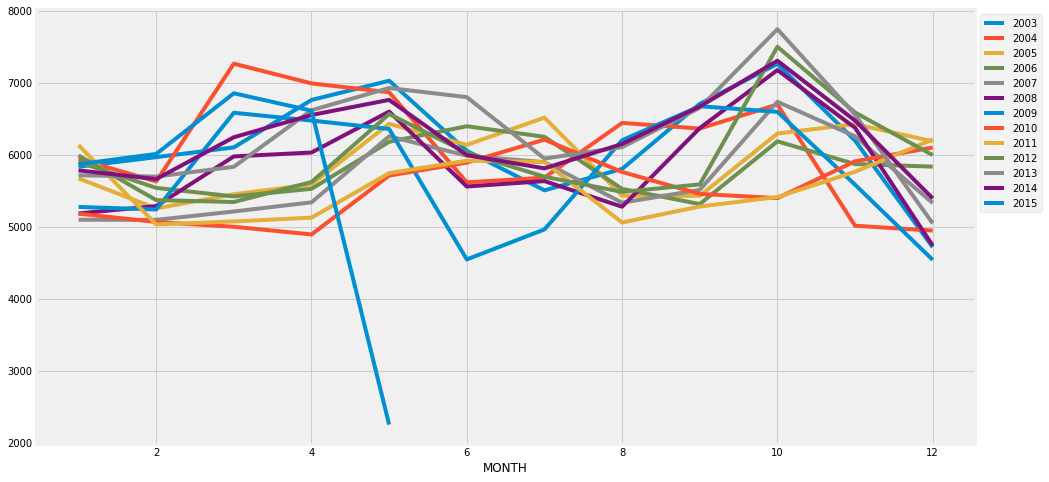

In [6]:
# Look at crimes by month to find seasonality effects
df.groupby([df.MONTH, df.YEAR]).Dates.count().unstack().plot(figsize=(15,8)).legend(bbox_to_anchor=(1, 1))

Looking at crime per month does show slight seasonality, however the trend doesn't appear consistent for each year of the data. The peak in October presents in 5 years of the data but is pretty much missing in the other 7 years. There does appear to be a slight downturn in crime reports in June, July, and August, but the trend is not very large.

In [7]:
# Look at days of the year
df['DM'] = df.Dates.map(lambda x: x.strftime('%m-%d')) 
df.DM.value_counts()[0:10]

11-01    5346
01-25    5275
02-22    4997
01-11    4971
02-08    4960
04-04    4887
10-31    4858
03-08    4856
04-19    4845
01-10    4829
Name: DM, dtype: int64

However, when we aggregate by day of the year, we can see that the pattern is not so predicable. We had hypothesized that holidays would possibly present a higher crime rate (New Years Eve, Fourth of July, etc), however none of those dates are in the top 10 of days when crimes take place. 

In [8]:
# Regroup dates into day of the week
print("Day of Week: ")
print(df.DayOfWeek.value_counts().sum())
print(df.DayOfWeek.value_counts())

Day of Week: 
878049
Friday       133734
Wednesday    129211
Saturday     126810
Thursday     125038
Tuesday      124965
Monday       121584
Sunday       116707
Name: DayOfWeek, dtype: int64


A breakdown of crimes by day of the week shows little variation. It seems that crimes occur on all days of the week and are not segegrated to weekends or other days. 

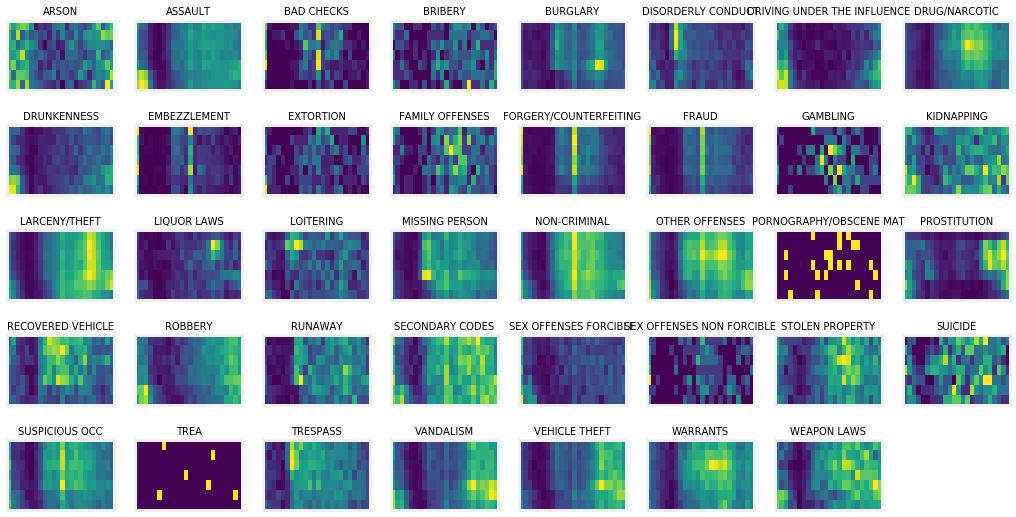

In [9]:
# Look at the data by type of crime by hour reported to identify any trends by crime type
cats = pd.Series(df.Category.values.ravel()).unique()
cats.sort()

plt.figure(2,figsize=(16,9))
plt.title("Day vs Hour by Crime Type")
plt.subplots_adjust(hspace=0.5)
for i in np.arange(1,len(cats) + 1):
    ax = plt.subplot(5,8,i)
    ax.set_title(cats[i - 1],fontsize=10)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.hist2d(
        df[df.Category==cats[i - 1]].Dates.dt.hour.values,
        df[df.Category==cats[i - 1]].Dates.dt.weekday.values, 
        bins=[24,7],
        range=[[-0.5,23.5],[-0.5,6.5]]
    )
    plt.gca().invert_yaxis()
    

These 2-dimensional heat plots show day of the week on the y-axis and hour of the day on the x-axis. High crime time and day combinations appear as a brigher yellow color, while darker areas show no crimes. We can see that most crimes have peak times during waking hours (ie, the plots are dark from around 2:00 AM to 6:00 AM. A few crimes have clear spikes in the middle of the day (for instance forgery/counterfeiting, fraud, and embezzlement). The nature of these crimes seems more premeditated so it's possible this timing trend has more to do with when the crime is reported rather than when the crime is committed. 

Looking at crime by hour, there is a general trend for crime to hit a low point in the early hours of the morning, but there does appear to be some crimes that have spikes at noon and 6pm.

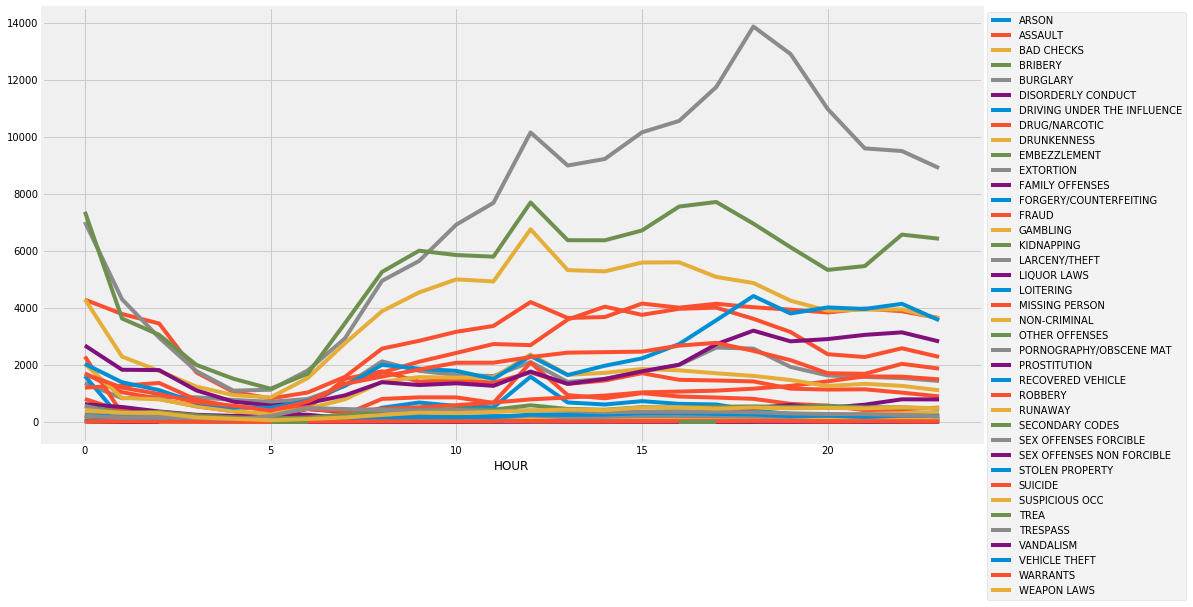

In [10]:
df.groupby([df.HOUR, 'Category']).Dates.count().unstack().plot(figsize=(15,8)).legend(bbox_to_anchor=(1, 1))

Plotting a similar chart of crimes at minutes during the hour reveals that some are distributed fairly evenly throughout the hour, while others have a majority reported only on the hour and at half past the hour.

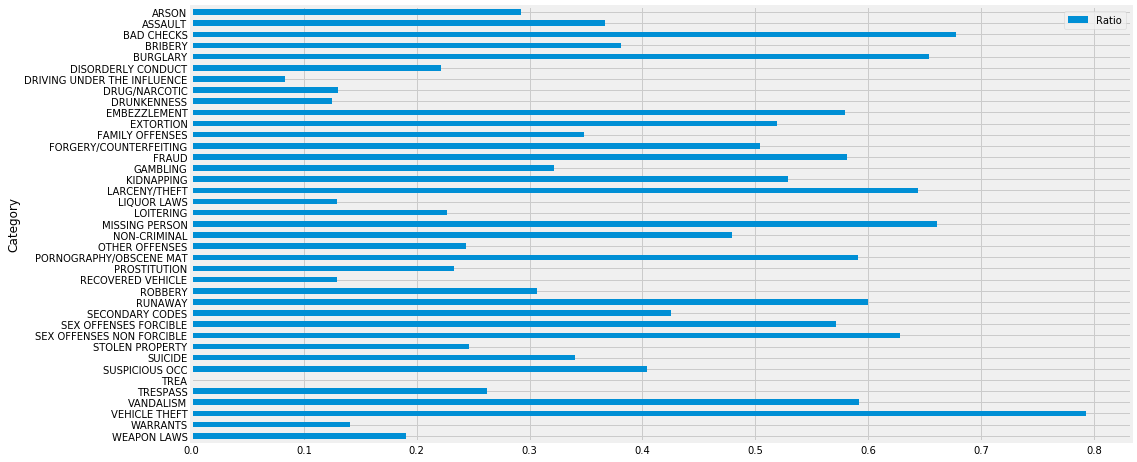

In [11]:
# Further split the data by minute and isolate those commited with min=0 or min=30
df['MIN'] = df.Dates.dt.minute
df['MIN_split'] = ((df.MIN == 0) | (df.MIN == 30))

# Find the ratio of crimes committed with min=0 or min=30 to total crimes for that category
minsplit = []
for cat in df.Category.unique():
    qwe = df[df.Category == cat]
    minsplit +=[[(qwe.MIN_split.sum() / qwe.MIN_split.count()), cat]]

# Plot the results
minsplit = pd.DataFrame(minsplit)
minsplit.columns = ['Ratio', 'Category']
minsplit.index = minsplit.Category
minsplit = minsplit.sort_index(ascending = False)
minsplit.plot.barh(figsize=(15,8))

This is may be a result of police reporting rather than when the crime actually occured. Above we plotted the ratio of crimes committed at 0 or 30 minutes past the hour to total crimes by crime type. The high ratios of many of the crimes suggest the gradiation in reporting time might not be a great metric because most crimes are reported at 0 or 30 minutes past the hour. 

### b. Location data

In [12]:
# Check values for addresses
print df.Address.value_counts()
df12 = df.groupby('Address').filter (lambda x: len(x) == 1)
print "\nNumber of addresses with single entry:", len(df12)

800 Block of BRYANT ST             26533
800 Block of MARKET ST              6581
2000 Block of MISSION ST            5097
1000 Block of POTRERO AV            4063
900 Block of MARKET ST              3251
0 Block of TURK ST                  3228
0 Block of 6TH ST                   2884
300 Block of ELLIS ST               2703
400 Block of ELLIS ST               2590
16TH ST / MISSION ST                2504
1000 Block of MARKET ST             2489
1100 Block of MARKET ST             2319
2000 Block of MARKET ST             2168
100 Block of OFARRELL ST            2140
700 Block of MARKET ST              2081
3200 Block of 20TH AV               2035
100 Block of 6TH ST                 1887
500 Block of JOHNFKENNEDY DR        1824
TURK ST / TAYLOR ST                 1810
200 Block of TURK ST                1800
0 Block of PHELAN AV                1791
0 Block of UNITEDNATIONS PZ         1789
0 Block of POWELL ST                1717
100 Block of EDDY ST                1681
1400 Block of PH

Here we see a similar problem as with crime type: most of the crimes occur at only a few addresses and over 2000 addresses only saw a single entry in the data set. This variable is very highly skewed and will likely also cause problems when training our predictive model in future steps. 

In [13]:
# check values for X,Y coordinates
print df.X.describe()
print '\n', df.Y.describe()

count    878049.000000
mean       -122.422616
std           0.030354
min        -122.513642
25%        -122.432952
50%        -122.416420
75%        -122.406959
max        -120.500000
Name: X, dtype: float64

count    878049.000000
mean         37.771020
std           0.456893
min          37.707879
25%          37.752427
50%          37.775421
75%          37.784369
max          90.000000
Name: Y, dtype: float64


We can see from the summary of the longitude and latitude values that there are some values that don't make sense in the dataset. The coordinates for the city of San Francisco are 122 degrees east and 37 degrees north. It seems like the latitude values start at 120 degrees east which would not be in the city and the longitude values extend all the way to 90 degrees north. 

In [14]:
# Adjust to remove out of range X,Y values
df = df[df.X < -121]
df = df[df.Y < 80]
df.shape


(877982, 16)

We've decided to remove these values because the model should only be trained on correct data, and there are only 67 rows with incorrect data. 

### (i). Blocks vs Intersections

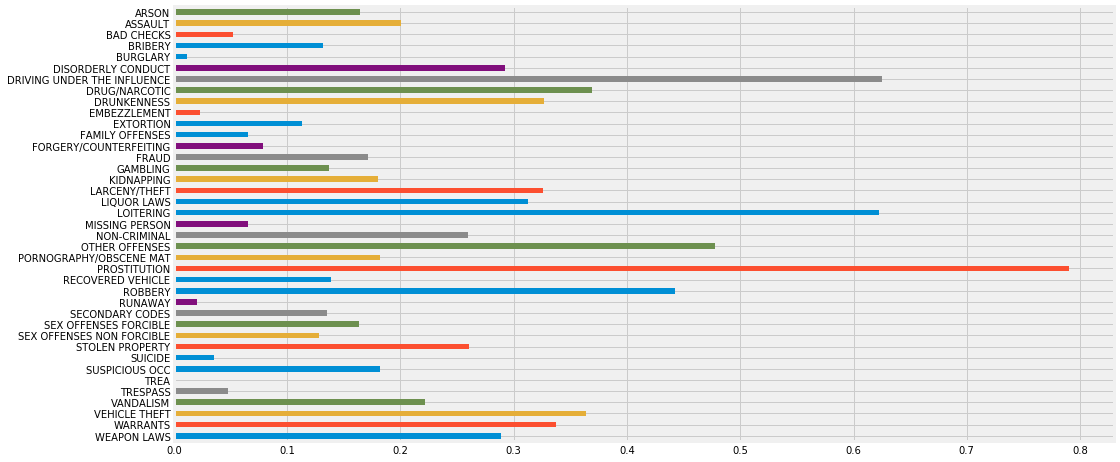

In [15]:
# Intersection data has a /, so we use that as an identifier
dfi = df[df.Address.str.contains(' / ')]

# show ratio of crime types in intersections vs whole database
dfi_ratio = dfi.Category.value_counts() / df.Category.value_counts()
dfi_ratio = dfi_ratio.sort_index(ascending = False)
dfi_ratio.plot.barh(figsize=(15,8))

The above plot shows the ratio of crimes committed at an intersection to total crimes by category. The high rates for prostitution, loitering and driving under the influence may help to identify these less common crimes. 

I guess we are fully confirming stereotypes in this plot because prostitution really does have a higher ratio of crimes committed at intersections.

### (ii). Analysis of Crime by District

In [16]:
# Look at the data by district
print("\nDistrict: ")
print(df.PdDistrict.value_counts().sum())
print(df.PdDistrict.value_counts())


District: 
877982
SOUTHERN      157174
MISSION       119907
NORTHERN      105284
BAYVIEW        89422
CENTRAL        85455
TENDERLOIN     81794
INGLESIDE      78841
TARAVAL        65592
PARK           49311
RICHMOND       45202
Name: PdDistrict, dtype: int64


It appears that most crimes occur in the Southern district, however, the data by district is not nearly as skewed as it is by previous metrics.

Text(0,0.5,'Number of Crimes')

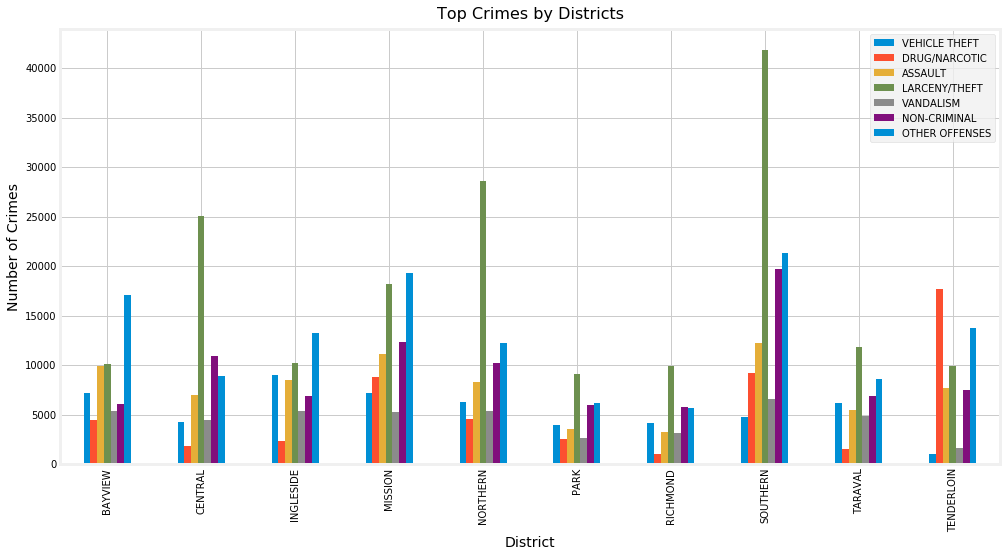

In [17]:
# Group by District and Category

grouped_dist = pd.DataFrame(df.groupby(['PdDistrict','Category']).count())
grouped_dist.reset_index(inplace=True)
#grouped_dist.rename(columns = {'ID':'Incidence_Count'},inplace=True)
grouped_dist_wide = grouped_dist.pivot(index='PdDistrict', columns='Category', values = 'Dates')

# crimes by district for top categories
top_7 = df.Category.value_counts().head(7)
top_7_ls = list(dict(top_7).keys())
fig, ax = plt.subplots(figsize=(15, 8))
ax = grouped_dist_wide[top_7_ls].plot(ax=ax, kind='bar')
ax.set_facecolor('white')
# Add some more Labeling
ax.legend(loc="upper right", fontsize=10)
plt.title("Top Crimes by Districts",  y=1.01, size=16)
plt.xlabel("District",size=14)
plt.ylabel("Number of Crimes", size=14)

Above is a plot of the top crimes per district. We can see that Larceny/Theft is the highest crime type in the Central, Northern, and Southern districts. Note the y-axis values in the plot above extend up to 40,000 crimes. While there are a couple of notable differences, such as the high rate of drug crime in the Tenderloin, there is not a huge disparity in crime type across district.  

Text(0,0.5,'Number of Crimes')

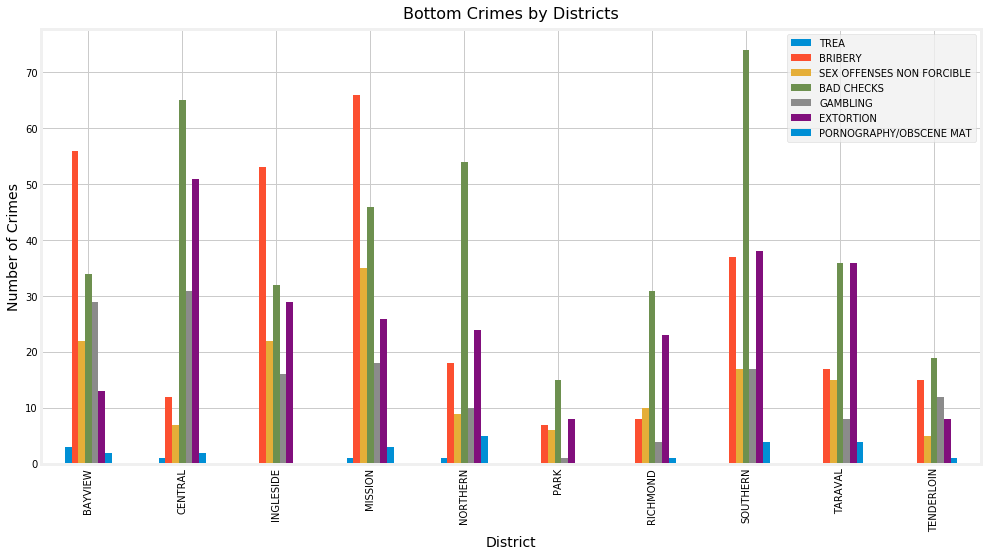

In [19]:
# crimes by district for bottom categories
bot_7 = df.Category.value_counts().tail(7)
bot_7_ls = list(dict(bot_7).keys())
fig, ax = plt.subplots(figsize=(15, 8))
ax = grouped_dist_wide[bot_7_ls].plot(ax=ax, kind='bar')
ax.set_facecolor('white')
# Add some more Labeling
ax.legend(loc="upper right", fontsize=10)
plt.title("Bottom Crimes by Districts",  y=1.01, size=16)
plt.xlabel("District",size=14)
plt.ylabel("Number of Crimes", size=14)

An analysis of the least common crimes per district shows that bribery and bad checks seem to dominate most districts. Here we can see how few of these crimes occur in each district by noting the y-axis only extends up to 70 crimes.

## II. Machine Learning

In this section of the analysis, we begin our machine learning portion. Here we create features based on various breakdowns of the datetime variable as well as futher location-based clustering and school-distance features. 

In [20]:
# Import test data - parsing dates in column 1
df_test = pd.read_csv('test.csv', parse_dates=[1])
df_test.shape

(884262, 7)

Note the kaggle test data set is slightly larger than the training set and covers the same period.

SF Data has information on school location and we decide to include it to create a feature related to school proximity

In [21]:
# Import SF school data
df_sch = pd.read_csv('schools.csv')
df_sch.columns

Index([u'Campus Name', u'CCSF Entity', u'Lower Grade', u'Upper Grade',
       u'Grade Range', u'Category', u'Map Label', u'Lower Age', u'Upper Age',
       u'General Type', u'CDS Code', u'Campus Address', u'Supervisor District',
       u'County FIPS', u'County Name', u'Location 1'],
      dtype='object')

In [22]:
# Create dataframe of unique addresses
df_addr = df.drop_duplicates(subset = 'Address')
df_addr = df_addr[['Address', 'X', 'Y']]
df_addr = df_addr.reset_index(drop=True)
df_addr.head()
print df_addr.shape

(23191, 3)


#### A. Functions for feature engineering and data processing

In [23]:
# Strip X Y data from school dataset
def school_proximity(dist, df):
    """add column to training data based on proximity to school"""
    df_sch = pd.read_csv('schools.csv')
    df_sch['Y'] = df_sch['Location 1'].str.findall('\d\d\.\d+').str.get(0).astype('float64')
    df_sch['X'] = df_sch['Location 1'].str.findall('\-\d{3}\.\d+').str.get(0).astype('float64')
    df_sch = df_sch[['Campus Name','X','Y']]

    # create list of closest distance of each address to any school 
    closest_dist = []

    for i in range(len(df_addr)):
        df_sch['sch_dist'] = ((((df_addr.X[i]-df_sch.X)*88000)**2) + ((df_addr.Y[i]-df_sch.Y)*111000)**2)**0.5
        closest_dist.append(min(df_sch.sch_dist))
    
    # add closest distance to df_addr dataframe
    df_addr['closest_dist'] = closest_dist

    # filter based on 100m distance
    df_addr['by_school'] = df_addr.closest_dist < dist

    # create dataframe with addresses and true false proximity to school
    newgroup = df_addr[['Address','by_school']]
    newgroup[newgroup.by_school == True]
    
    # create a map and map to df
    mapper = newgroup.set_index('Address')['by_school']
    df['by_school'] = df['Address'].map(mapper)


The above function calculates the proximity of each crime location to the closest school within San Francisco. 

We also want to group the 23,000+ addresses into a manageable number for training purposes. A address can be defined by the volume of crime and also by the distribution of crime at that particular address. Distribution is measured by the ratio of the amount of a type of crime to the total amount of crime at that address.

In [24]:
def group_by_vol(num_group, df):
    """Create groups of addresses based on total volume of crime"""
    df_addr_vol = df_train.Category.groupby(df_train.Address).value_counts().unstack(level=0).fillna(value=0).T
    x = df_addr_vol.values
    
    # Use MinMaxScaler to rescale features by given range
    min_max_scaler = MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_addr_vol_sc = pd.DataFrame(x_scaled)
    
    # Run Agglomerative Clustering model, the number of clusters is specified in the function call
    agclv = AgglomerativeClustering(n_clusters=num_group)
    addr_grp_vol = agclv.fit_predict(df_addr_vol_sc)
    
    # Add feature to dataframe
    df_addr_vol['Addr_Group_V'] = addr_grp_vol
    df_addr_vol['Address'] = df_addr_vol.index
    newgroupv = df_addr_vol[['Address','Addr_Group_V']]
    
    # create a map and map to df
    mapper = newgroupv.set_index('Address')['Addr_Group_V']
    df['Addr_Group_V'] = df['Address'].map(mapper)
     

In [25]:
def group_by_ratio(num_group, df):
    """Group addresses by ratio of crime"""
    df_addr_ratio = df_train.Category.groupby(df_train.Address).value_counts().unstack(level=0).fillna(value=0).T
    df_addr_ratio = (df_addr_ratio.T / df_addr_ratio.T.sum()).T
    df_addr_ratio.head(6)
    
    # Fit Agglomerative Clustering algorithm; number of clusters is a function parameter
    agclr = AgglomerativeClustering(n_clusters = num_group)
    addr_grp_ratio = agclr.fit_predict(df_addr_ratio)
    
    df_addr_ratio['Addr_Group_R'] = addr_grp_ratio
    df_addr_ratio['Address'] = df_addr_ratio.index
    newgroupr = df_addr_ratio[['Address','Addr_Group_R']]
    
    # create a mapper and map to df
    mapper = newgroupr.set_index('Address')['Addr_Group_R']
    df['Addr_Group_R'] = df['Address'].map(mapper)

A data set can now be created with all possible features 

In [26]:
# Add feature columns to data frame 
def process_data(sdist, vnum, rnum, df):
    """Preprocess dataframe"""
    
    # Add school and clustering features from previous three functions
    school_proximity(sdist, df)
    group_by_vol(vnum, df)
    group_by_ratio(rnum, df)
    
    # Derive date related information
    df['YEAR'] = df.Dates.dt.year
    df['MONTH'] = df.Dates.dt.month
    df['DOM'] = df.Dates.dt.day
    df['DOW'] = df.Dates.dt.weekday
    df['HOUR'] = df.Dates.dt.hour
    df['MIN'] = df.Dates.dt.minute
    df['MIN_split'] = ((df.MIN == 0) | (df.MIN == 30))
    df['HOUR_RATIO'] = ((df.HOUR) == 12 | (df.HOUR == 18))
    
    # Add a few specific date variables
    df['DM'] = df.Dates.map(lambda x: x.strftime('%m-%d'))
    df['FOJ'] = ((df.DM) == 07-04)
    df['NYE'] = ((df.DM) == (12-31 | 01-01))
    
    # Additional address related information
    df['Block_split'] = df.Address.str.contains('Block')
    df['X_norm'] = (df.X-df.X.mean()) / (df.X.max() - df.X.min())
    df['Y_norm'] = (df.Y-df.Y.mean()) / (df.Y.max() - df.Y.min())
    
    # Combined Date and Address information
    df['Year_District'] = df.YEAR.astype(str).str.cat(df.PdDistrict.astype(str), sep=' ')
    
    return df
    

In [27]:
# Convert dataframe columns to dummy variables and assemble the relevant columns
def assemble(df):
    """Create dataframe suitable for machine learning"""
    
    # Binarize information where necessary
    df_YEAR_DISTRICT = pd.get_dummies(df.Year_District, prefix = 'Year_District')
    df_YEAR = pd.get_dummies(df.YEAR, prefix = 'Month')
    df_MONTH = pd.get_dummies(df.MONTH, prefix = 'Month')
    df_DOM = pd.get_dummies(df.DOM, prefix = 'DofM')
    df_DOW = pd.get_dummies(df.DOW, prefix = 'DofW')
    df_HOUR = pd.get_dummies(df.HOUR, prefix = 'Hour')
    df_DISTRICT = pd.get_dummies(df.PdDistrict, prefix = 'District')
    df_ADDR_GP_V = pd.get_dummies(df.Addr_Group_V, prefix = 'AddrV')
    df_ADDR_GP_R = pd.get_dummies(df.Addr_Group_R, prefix = 'AddrR')
    df_FOJ = pd.get_dummies(df.FOJ, prefix = 'FOJ')
    df_NYE = pd.get_dummies(df.NYE, prefix = 'NYE')
    
    # Concatenate specific fields into dataframe
    new = pd.DataFrame(data=None, index = df.index)
    
    # Date Fields
    #new = pd.concat([new, df_YEAR], axis = 1)
    new = pd.concat([new, df_MONTH], axis = 1)
    #new = pd.concat([new, df_DOM], axis = 1)
    #new = pd.concat([new, df_DOW], axis = 1)
    #new = pd.concat([new, df_HOUR], axis = 1)
    new = pd.concat([new, df.HOUR_RATIO], axis = 1)
    new = pd.concat([new, df.MIN_split], axis = 1)
    #new = pd.concat([new, df.FOJ], axis = 1)
    #new = pd.concat([new, df.NYE], axis = 1)
   
    # Address Fields
    #new = pd.concat([new, df.Y_norm, df.X_norm], axis = 1)
    #new = pd.concat([new, df_ADDR_GP_V], axis = 1)
    #new = pd.concat([new, df_DISTRICT], axis = 1)
    new = pd.concat([new, df.by_school], axis = 1)
    new = pd.concat([new, df_ADDR_GP_R], axis = 1)
    new = pd.concat([new, df_ADDR_GP_V], axis = 1)
    new = pd.concat([new, df.Block_split], axis = 1)
   
    # Combination Fields
    #new = pd.concat([new, df_YEAR_DISTRICT], axis = 1)
    
    new = new.fillna(0)
    
    print 'Full dataset shape: ', new.shape
    
    return new

In [32]:
# Function to determine cross validation score of training data using Bernoulli Naive Bayes model
def train_test_nb(df_adj): 
    nb = BernoulliNB()
    print '\nNB Cross Val Score', cross_val_score(nb, df_adj, df_train.Category, scoring = 'neg_log_loss').mean()  

In [29]:
# Define and fit a Bernoulli Naive Bayes model using the training data and predict crime type on the test data
def test_predict(df, train):
    nb = BernoulliNB()
    nb.fit(train, df_train.Category)
    #nb.fit(assemble(process_data(40,3,500,df_train)), df_train.Category)
    y_pred = nb.predict(df)
    print y_pred[:20]
    print y_pred.shape
    
    return y_pred

#### B. Run NB model with parameters for school distance and number of groups for address by crime vol and ratio 

In [30]:
# Process and assemble the training data
# Arguments for function: process_data(sdist, vnum, rnum, df)
df_trainset = assemble(process_data(40,3,500,df_train))

Full dataset shape:  (877982, 519)


In [31]:
# Process and assemble the test data
df_testset = assemble(process_data(40,3,500,df_test))

Full dataset shape:  (884262, 519)


In [33]:
# Determine the Cross validation score for the training set
train_test_nb(df_trainset)


NB Cross Val Score -2.356761949637486


In [ ]:
# Determine predictions on the test data using our model defined above
results = test_predict(df_testset, df_trainset)

In [ ]:
# Process output into correct submission file
train_labels = df_train.Category.astype('category')
submit = pd.DataFrame({'Id': df_test.Id.tolist()})
for category in train_labels.cat.categories:
    submit[category] = np.where(results == category, 1, 0)
    
submit.to_csv('submission_final.csv', index = False)

## III. Conclusions

In this project, we analyzed 12 years of San Francisco crime data and attempted to train a model to predict types of crime based on location and time data. The high skew in both type of crime and location found in the training data made the project very difficult. 

In the end our kaggle competition score was 24.98749. Our initial submission score was 28.67978 so we were able to improve our results over the past few weeks, but we definitely have additional room for improvement. 

We didn't find a really excellent solution to the extreme biases found in both the categories and addresses found in the training set. Additionally, the large dataset caused many problems when attempting to run other machine learning algorithms. A KNN-model might have been better because of the location data, however, after several attempts to speed up the algorithm, we still could not get it to run in any manageable time frame which made it extremely difficult to work with. 

Further analysis could definitely be done to improve our score. It's possible using a different type of clustering algorithm like DBSCAN or hierarchical clustering could produce better predictions on the test set. 

In [ ]:
from IPython.display import Image
Image("kaggle.png")

### IV. Appendix

Here we briefly include a few other steps we took to determine our final algorithm and output. 

Before running on the full training data set, we tested using train / test split. In addition we assessed progress using logloss score using cross validation on the training set (shown above). We tried oversampling to improve the accuracy for low occurring crime types. We tried other models and tested various values of alpha for naive bayes. Finally we used various cluster sizes for addresses to determine the most appropriate values. 

In [34]:
def newnb(df_adj):
    
    X_train, X_dev, y_train, y_dev = train_test_split(df_adj, df.Category, test_size = 0.5, stratify = df.Category, random_state = 42)
    nb2 = BernoulliNB()
    nb2.fit(X_train, y_train)
    y_prednb = nb2.predict(X_dev)
    print 'Standard NB Score\n', metrics.classification_report(y_dev, y_prednb)

In [35]:
newnb(assemble(process_data(40, 3, 500, df_train)))

Full dataset shape:  (877982, 519)
Standard NB Score
                             precision    recall  f1-score   support

                      ARSON       0.80      0.01      0.01       756
                    ASSAULT       0.18      0.31      0.23     38436
                 BAD CHECKS       0.00      0.00      0.00       203
                    BRIBERY       0.00      0.00      0.00       144
                   BURGLARY       0.20      0.20      0.20     18377
         DISORDERLY CONDUCT       0.38      0.01      0.01      2159
DRIVING UNDER THE INFLUENCE       0.28      0.02      0.04      1134
              DRUG/NARCOTIC       0.28      0.39      0.32     26986
                DRUNKENNESS       0.33      0.00      0.00      2140
               EMBEZZLEMENT       0.00      0.00      0.00       583
                  EXTORTION       0.00      0.00      0.00       128
            FAMILY OFFENSES       0.00      0.00      0.00       245
     FORGERY/COUNTERFEITING       0.20      0.01 

C:\Users\dcrha\Anaconda3\envs\Python27\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
# We used this function to find the oversample score and confusion matrix for a Naive Bayes model to determine if 
# oversampling could help with the enormous class imbalance. 

def ros(df_adj):
    
    X_train, X_dev, y_train, y_dev = train_test_split(df_adj, df.Category, test_size = 0.5, stratify = df.Category, random_state = 42)

    dict = df.Category.value_counts()
    dict = np.log2(dict)
    dict = dict / dict.sum()
    dict = (dict*2347000)
    dict = dict.astype(int)
    dict = dict.to_dict()

    from imblearn.over_sampling import RandomOverSampler
    ros = RandomOverSampler(ratio = dict, random_state = None)
    X_resampled, y_resampled = ros.fit_sample(X_train, y_train)
    
    nb1 = BernoulliNB()
    nb1.fit(X_resampled, y_resampled)
    y_prednb = nb1.predict(X_dev)
    print 'Oversampled NB Score\n', metrics.classification_report(y_dev, y_prednb)
    print 'Oversampled confusion matrix', metrics.confusion_matrix(y_dev, y_prednb)
    
    
    nb2 = BernoulliNB()
    nb2.fit(X_train, y_train)
    y_prednb2 = nb2.predict(X_dev)
    print 'Standard NB Score\n', metrics.classification_report(y_dev, y_prednb2)
    

In [ ]:
ros(assemble(pro_df))

In [36]:
def train_test_rf(df_adj): 
    rf = RandomForestClassifier()
    print '\nNB Cross Val Score', cross_val_score(rf, df_adj, df_train.Category, scoring = 'neg_log_loss').mean() 

In [37]:
# Determine the Cross validation score for the training set
train_test_rf(df_trainset)


NB Cross Val Score -5.435846621933689


In [ ]:
# Attempted KNN algorithm
kn = KNeighborsClassifier(n_neighbors = 2, metric = 'dice')
print '\nKNN Cross Val Score', cross_val_score(kn, assemble(pro_df), df.Category, scoring = 'neg_log_loss').mean()